In [13]:
import numpy as np
import pandas as pd
import xarray as xr
from xhistogram.xarray import histogram
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
from matplotlib import rcParams, ticker, cm

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### Open sample data
No QC is being used for this tutorial

In [3]:
file = '/scratch1/NCEPDEV/da/Kevin.Dougherty/DARTH/amsua_n19_hofx_gfs_2020-12-16T21:00:00Z.nc4'

ds = xr.open_dataset(file)
validvars = [var for var in list(ds.keys()) if var.endswith(('@hofx', '@EffectiveQC',
                                                             '@EffectiveError', '@ObsBias',
                                                             '@GsiHofXBc', '@PreQC',
                                                             '@GsiFinalObsError', 'latitude@MetaData',
                                                             'longitude@MetaData'))]

df = ds[validvars].to_dataframe()

df

,brightness_temperature_1@PreQC,brightness_temperature_1@EffectiveQC,brightness_temperature_10@PreQC,brightness_temperature_10@EffectiveQC,brightness_temperature_11@PreQC,brightness_temperature_11@EffectiveQC,brightness_temperature_12@PreQC,brightness_temperature_12@EffectiveQC,brightness_temperature_13@PreQC,brightness_temperature_13@EffectiveQC,...,brightness_temperature_8@ObsBias,brightness_temperature_8@EffectiveError,brightness_temperature_8@hofx,brightness_temperature_9@GsiFinalObsError,brightness_temperature_9@GsiHofXBc,brightness_temperature_9@ObsBias,brightness_temperature_9@EffectiveError,brightness_temperature_9@hofx,latitude@MetaData,longitude@MetaData
nlocs,,,,,,,,,,,,,,,,,,,,,
0,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.182202,NaN,214.643051,0.250007,217.742355,-0.348505,0.250006,217.728455,-86.515503,11.392600
1,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.400047,NaN,215.612198,0.250006,216.682724,-0.698139,0.250006,216.677582,-76.463997,18.673901
2,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.747304,NaN,216.595673,0.250007,217.726151,-0.961956,0.250006,217.723618,-71.291801,24.991100
3,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.634131,NaN,217.469971,0.250006,217.875015,-0.593663,0.250005,217.863052,-65.656403,24.236700
4,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.971210,NaN,212.792786,0.250006,214.863403,-0.232083,0.250005,214.851654,-82.722801,37.968102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9092,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.374577,NaN,212.142212,0.250008,203.668884,-1.285095,0.250007,203.666748,-16.346300,311.379608
9093,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.468785,NaN,213.569504,0.250005,215.214325,-0.256490,0.250005,215.202286,-81.319801,348.330902
9094,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.393204,NaN,217.412979,0.250006,220.348099,-0.664964,0.250006,220.322708,-74.278503,339.351013


In [58]:
# set figure params one time only.
rcParams['figure.subplot.left'] = 0.1
rcParams['figure.subplot.top'] = 0.85
rcParams['legend.fontsize'] = 12
rcParams['axes.grid'] = False

def _get_linear_regression(data1, data2):
    """
    Inputs:
        data1 : data on the x axis
        data2 : data on the y axis
    """
    x = np.array(data1).reshape((-1, 1))
    y = np.array(data2)
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    intercept = model.intercept_
    slope = model.coef_[0]
    # This is the same as if you calculated y_pred
    # by y_pred = slope * x + intercept
    y_pred = model.predict(x)
    return y_pred, r_sq, intercept, slope

def bin_df(df, variable, dlat=5, dlon=5, return_count=False):
    """
    Bin a variable from a datafram given dlat, dlon using xhistogram
    Input:
        df: dataframe that needs to binned
        variable: column from dataframe that needs to be binned
        dlat: latitude bin in degrees (Default: 5)
        dlon: longitude bin in degrees (Default: 5)
    Return:
        bindata: DataArray of binned data
    """
    bindata = df.reset_index(level=[0]).to_xarray()

    lon_bins = np.arange(0, 360+dlon, dlon)
    lat_bins = np.arange(-90, 90+dlat, dlat)

    # chunk data
    bindata_chunked = bindata.chunk({'index': '5MB'})

    count = histogram(bindata_chunked['latitude@MetaData'],
                        bindata_chunked['longitude@MetaData'],
                        bins=[lat_bins, lon_bins])

    # create bins with count
    bindata = histogram(bindata_chunked['latitude@MetaData'],
                        bindata_chunked['longitude@MetaData'],
                        bins=[lat_bins, lon_bins],
                        weights = bindata_chunked[variable])

    bindata = bindata / count.where(count > 1)

    if return_count:
        return bindata, count
    else:
        return bindata

def spatial_binned(binned_data, metadata):
    """
    Plot a global map of data that was binned using bin_df()
    Input:
        binned_data: DataArray of binned data
        metadata: dictionary of metadata
    Output:
        Saved .png file
    """
    
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cfeature.GSHHSFeature(scale='auto'))
    ax.set_extent([-180, 180, -90, 90])
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    cs = plt.pcolormesh(binned_data['longitude@MetaData_bin'], binned_data['latitude@MetaData_bin'],
                        binned_data.values, cmap=metadata['cmap'],
                        vmin=metadata['vmin'], vmax=metadata['vmax'],
                        transform=ccrs.PlateCarree())
    cb = plt.colorbar(cs, shrink=0.5, pad=.03, extend='both')
    cb.set_label(metadata['label'])
    plt.title(metadata['title'], loc='left')
    plt.title(metadata['cycle'], loc='right',fontweight='semibold')

#     plt.savefig(metadata['outfig'], bbox_inches='tight', pad_inches=0.1)
#     plt.close('all')

def spatial(df, metadata, variable=None):
    """
    Plot a global spatial map of data
    Input:
        df: dataframe with latitude/longitude data included
        variable: column from dataframe to be plotted (Default: None
                  plots spatial coverage)
        metadata: dictionary of metadata
    Output:
        Saved .png file
    """
    
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cfeature.GSHHSFeature(scale='auto'))
    ax.set_extent([-180, 180, -90, 90])
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    if variable is not None:
        cs = plt.scatter(df['longitude@MetaData'], df['latitude@MetaData'], c=df[variable], s=10,
                    cmap=metadata['cmap'], transform=ccrs.PlateCarree())
        cb = plt.colorbar(cs, shrink=0.5, pad=.03, extend='both')
        cb.set_label(metadata['label'])
        
    else:
        cs = plt.scatter(df['longitude@MetaData'], df['latitude@MetaData'], s=10,
                    color=metadata['cmap'], transform=ccrs.PlateCarree())
        
    
    plt.title(metadata['title'], loc='left')
    plt.title(metadata['cycle'], loc='right',fontweight='semibold')
    
#     plt.savefig(metadata['outfig'], bbox_inches='tight', pad_inches=0.1)
#     plt.close('all')

def scatter(dfX, dfY, metadata, density=False):
    # generate and save scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    y_pred, r_sq, intercept, slope = _get_linear_regression(dfX, dfY)
    if density:
        density_scatter(dfX.values, dfY.values, ax=ax, fig=fig,
                        bins=[100, 100], s=4, cmap='magma')
    else:
        plt.scatter(x=dfX, y =dfY, s=4, color='darkgray', label=f'n={dfX.count()}')
    label = f'y = {slope:.4f}x + {intercept:.4f}\nR\u00b2 : {r_sq:.4f}'
    plt.plot(dfX, y_pred, color='black', linewidth=1, label=label)
    plt.legend(loc='upper left', fontsize=11)
    plt.title(metadata['title'], loc='left')
    plt.xlabel(metadata['xlabel'], fontsize=12)
    plt.ylabel(metadata['ylabel'], fontsize=12)
    plt.title(metadata['cycle'], loc='right', fontweight='semibold')
#     plt.savefig(metadata['outfig'], bbox_inches='tight', pad_inches=0.1)
#     plt.close('all')
    
    return None

def lineplot(dfX, dfY, metadata):
    # generate and save line plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(dfX, dfY, linestyle=metadata['linestyle'], linewidth=metadata['linewidth'],
             color=metadata['color'], label=metadata['label'])
    plt.grid()
    plt.legend(loc='upper left', fontsize=11)
    plt.title(metadata['title'], loc='left')
    plt.xlabel(metadata['xlabel'], fontsize=12)
    plt.ylabel(metadata['ylabel'], fontsize=12)
    plt.title(metadata['cycle'], loc='right', fontweight='semibold')
#     plt.savefig(metadata['outfig'], bbox_inches='tight', pad_inches=0.1)
#     plt.close('all')

    return None

def density_scatter(x, y, ax=None, fig=None, sort=True, bins=20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None:
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    # To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, **kwargs)
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    #cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    # cbar.ax.set_ylabel('Density')
    return ax

### Spatial Plots

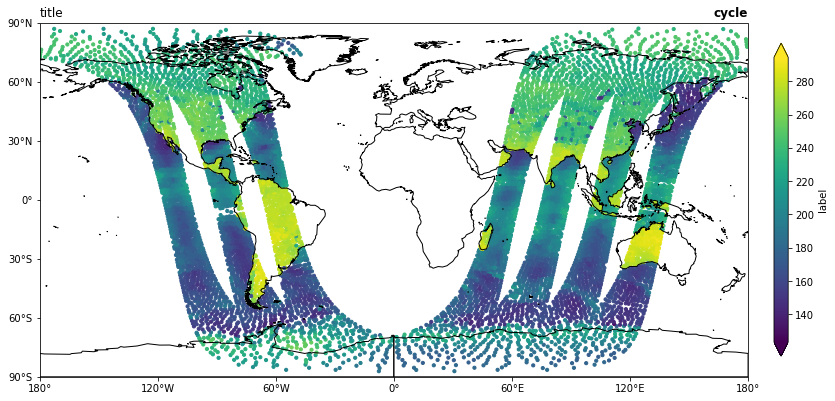

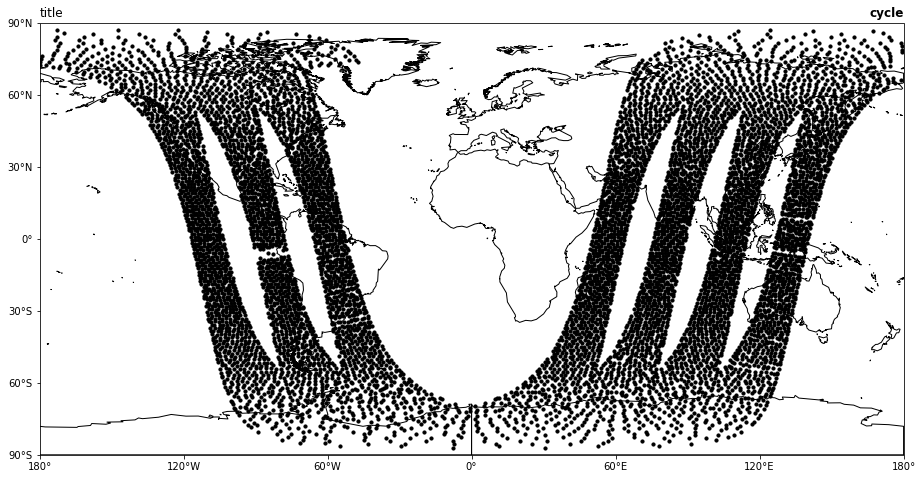

In [5]:
metadata = {'title': 'title',
            'cycle': 'cycle',
            'outfig': 'outfig',
            'cmap': 'viridis',
            'label': 'label'}

# Spatial of specific variable
spatial(df, metadata, variable='brightness_temperature_1@hofx')

# Spatial for just coverage
metadata = {'title': 'title',
            'cycle': 'cycle',
            'outfig': 'outfig',
            'cmap': 'black',
            'label': 'label'}

spatial(df, metadata)

### Binned Spatial Plot

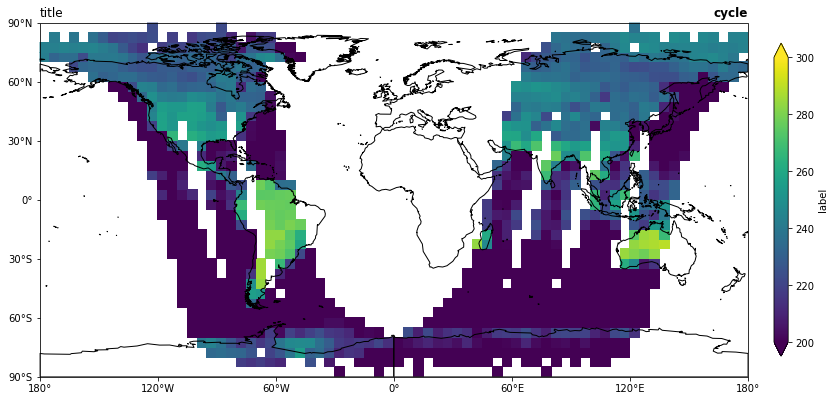

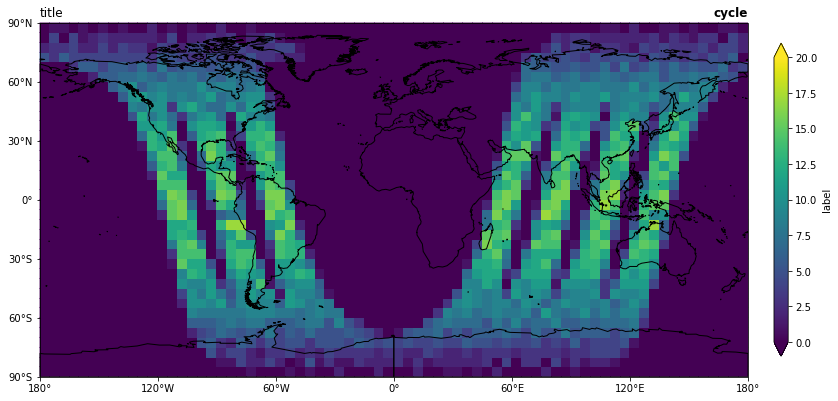

In [62]:
# bin data first
binned_data = bin_df(df, variable='brightness_temperature_1@hofx', dlat=5, dlon=5)

# plot binned data spatially
metadata = {'title': 'title',
            'cycle': 'cycle',
            'outfig': 'outfig',
            'cmap': 'viridis',
            'vmax': 300,
            'vmin': 200,
            'label': 'label'}

spatial_binned(binned_data, metadata)

# grab binned data and the count data as well
binned_data, count = bin_df(df, variable='brightness_temperature_1@hofx', dlat=5, dlon=5, return_count=True)

# plot obs count per bin
metadata = {'title': 'title',
            'cycle': 'cycle',
            'outfig': 'outfig',
            'cmap': 'viridis',
            'vmax': 20,
            'vmin': 0,
            'label': 'label'}

spatial_binned(count, metadata)

### Scatter Plots

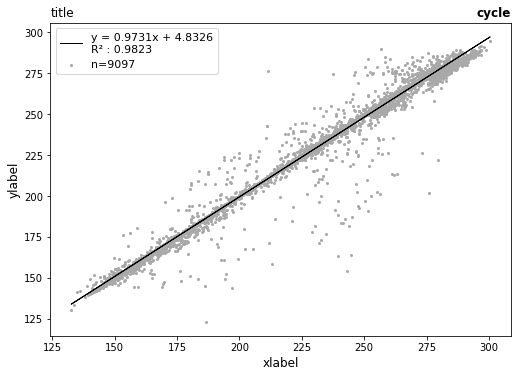

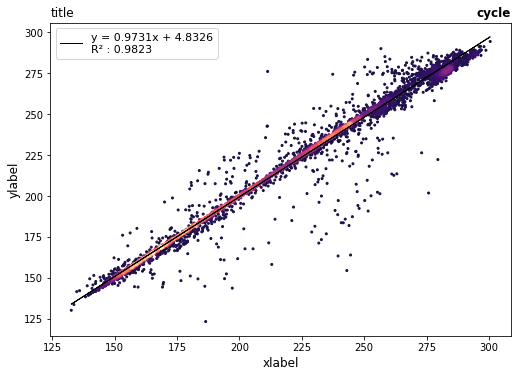

In [9]:
metadata = {'title': 'title',
            'xlabel': 'xlabel',
            'ylabel': 'ylabel',
            'cycle': 'cycle',
            'outfig': 'outfig'
           }

# Simple Scatter Plot w/ Regression line
scatter(df['brightness_temperature_1@GsiHofXBc'], df['brightness_temperature_1@hofx'], metadata=metadata)

# Density Scatter Plot w/ Regression Line
scatter(df['brightness_temperature_1@GsiHofXBc'], df['brightness_temperature_1@hofx'], metadata=metadata, density=True)

### Line Plot

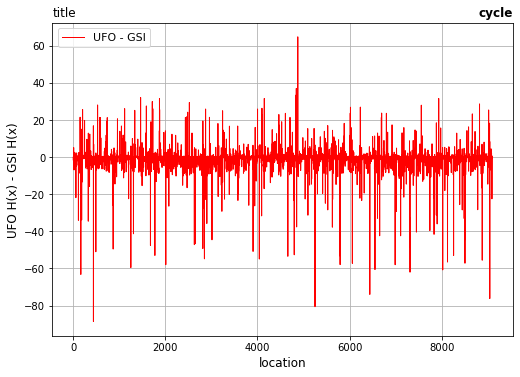

In [10]:
line_mdata = {'title': 'title',
              'cycle': 'cycle',
              'xlabel': 'location',
              'ylabel': 'UFO H(x) - GSI H(x)',
              'outfig': 'outfig',
              'linestyle': '-',
              'linewidth': 1,
              'color': 'red',
              'label': 'UFO - GSI'}

lineplot(df['brightness_temperature_1@hofx'].index,
         df[f'brightness_temperature_1@hofx']-df[f'brightness_temperature_1@GsiHofXBc'],
         line_mdata)